In [1]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold, cross_val_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import shap
import settings

In [2]:
regression_targets = f'{settings.raw_data_folder}control/regression_targets.csv'
control = f'{settings.processed_data_folder}control_selected_features.csv'

In [3]:
targets = pd.read_csv(regression_targets, index_col=False)

In [4]:
df = pd.read_csv(control, index_col=0)

In [5]:
df = pd.merge(targets, df, on='Country')

In [6]:
df.head()

,Deaths,Confirmed,Recovered,Country,Obesity,Population,Max Latitude,Max Longitude,Annual Average Temperature
0,0.006186,0.142134,0.123374,Afghanistan,0.037471,0.027721,0.602919,0.700916,0.689775
1,0.050951,2.967301,1.792636,Albania,0.454333,0.001985,0.639673,0.547690,0.671682
2,0.006558,0.244897,0.167572,Algeria,0.555035,0.031592,0.590785,0.521881,0.888663
3,0.001461,0.061687,0.056808,Angola,0.091335,0.023153,0.226062,0.556283,0.856803
4,0.108227,4.356147,3.905192,Argentina,0.599532,0.032320,0.073068,0.335135,0.696697


In [7]:
columns = df.columns.tolist()
columns.remove('Country')

In [8]:
features = df.columns.tolist()

In [9]:
features

['Deaths',
 'Confirmed',
 'Recovered',
 'Country',
 'Obesity',
 'Population',
 'Max Latitude',
 'Max Longitude',
 'Annual Average Temperature']

In [10]:
features.remove('Confirmed')
features.remove('Recovered')
features.remove('Deaths')
features.remove('Country')

In [11]:
df = df[df['Deaths'] != 0]

In [12]:
df = df.drop(['Confirmed', 'Recovered'], axis=1)

In [13]:
X = df[features]

In [14]:
Y = df['Deaths']

In [15]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [16]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
y_pred = model.predict(X_test)

In [18]:
pred_real = []
pred_real.append(y_pred.tolist())
pred_real.append(y_test.tolist())
pred_real.append(range(0, len(y_test.tolist())))

In [19]:
indexes = y_test.index.tolist()

In [20]:
test_countries = df.loc[indexes, :]['Country']

In [21]:
pred_real_df = pd.DataFrame(pred_real).T

In [22]:
pred_real_df.columns = ['Predicted', 'Real', 'No']

In [23]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE {mae: .4f}")

MAE  0.0255


In [24]:
print('==REAL= <=> =PRED==')
i = 0
for real, pred in zip(y_test, y_pred):
    print(f"{i}:{real: .3f}  <=>  {pred: .3f}  ")
    i+=1

==REAL= <=> =PRED==
0: 0.167  <=>   0.088  
1: 0.129  <=>   0.144  
2: 0.002  <=>   0.016  
3: 0.038  <=>   0.022  
4: 0.088  <=>   0.068  
5: 0.022  <=>   0.036  
6: 0.026  <=>   0.074  
7: 0.041  <=>   0.053  
8: 0.019  <=>   0.061  
9: 0.128  <=>   0.139  
10: 0.003  <=>   0.073  
11: 0.005  <=>   0.083  
12: 0.003  <=>   0.007  
13: 0.102  <=>   0.069  
14: 0.001  <=>   0.002  
15: 0.018  <=>   0.023  
16: 0.093  <=>   0.151  
17: 0.094  <=>   0.103  
18: 0.010  <=>   0.048  
19: 0.023  <=>   0.027  
20: 0.032  <=>   0.121  
21: 0.128  <=>   0.081  
22: 0.001  <=>   0.005  
23: 0.001  <=>   0.025  
24: 0.009  <=>   0.008  
25: 0.111  <=>   0.103  
26: 0.077  <=>   0.059  
27: 0.001  <=>   0.002  
28: 0.105  <=>   0.013  
29: 0.002  <=>   0.008  
30: 0.015  <=>   0.015  
31: 0.109  <=>   0.066  
32: 0.000  <=>   0.010  
33: 0.010  <=>   0.009  
34: 0.004  <=>   0.003  
35: 0.001  <=>   0.005  


In [25]:
pred_real_df['Country'] = test_countries.tolist()

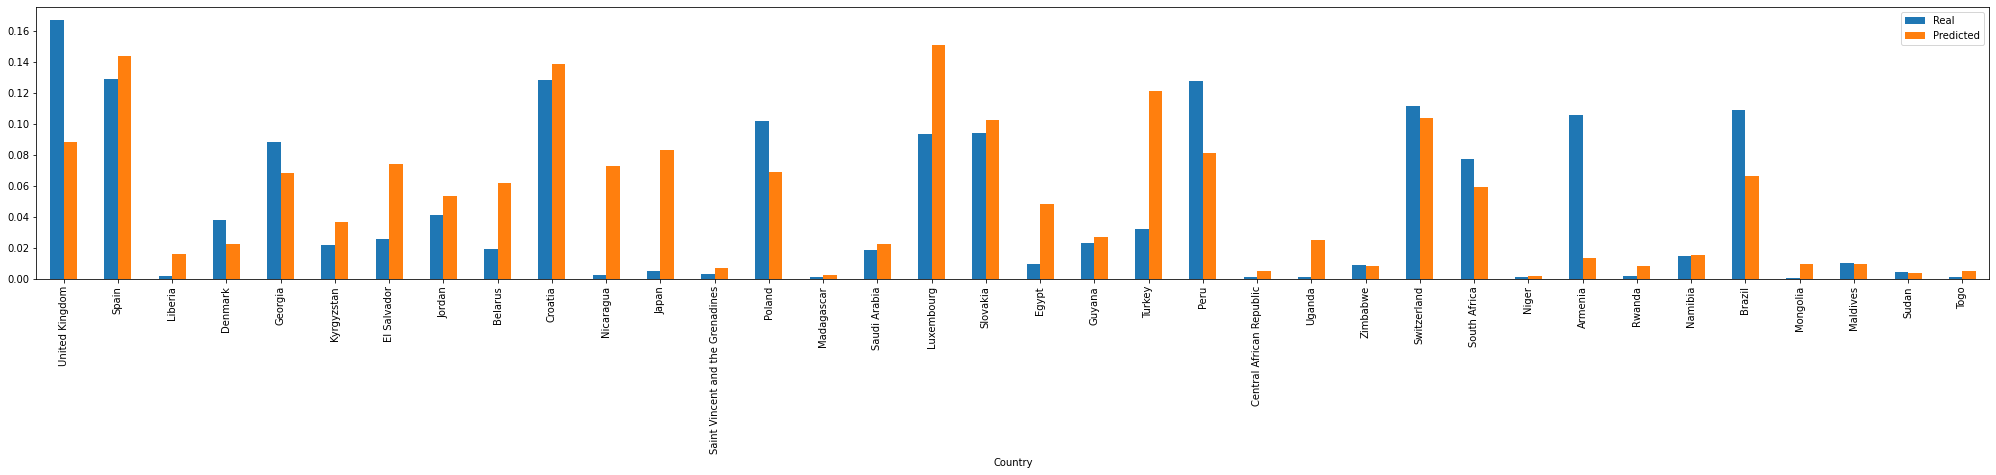

In [26]:
pred_real_df.plot(x="Country", y=["Real", "Predicted"], kind="bar", figsize=(35,5), width = 0.5)
plt.savefig(f'./control_predictions.png', dpi=300, bbox_inches = "tight")

In [27]:
print(model.feature_importances_)

[0.1609158  0.09291512 0.36782146 0.19457562 0.18377209]


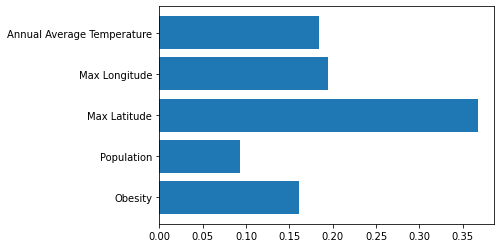

In [28]:
plt.barh(features, model.feature_importances_)
plt.show()

In [29]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

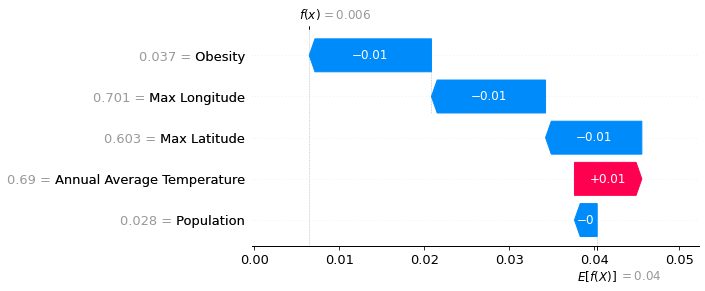

In [30]:
shap.plots.waterfall(shap_values[0])

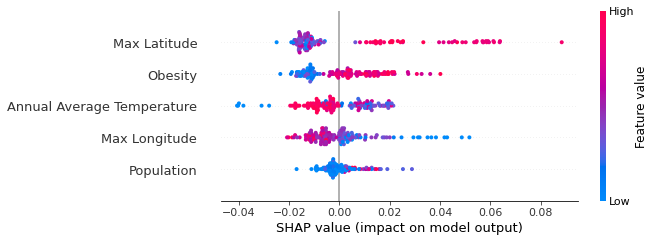

In [34]:
shap.plots.beeswarm(shap_values, show=False)
plt.savefig(f'./control_xgboost_shap.png', dpi=300, bbox_inches = "tight")

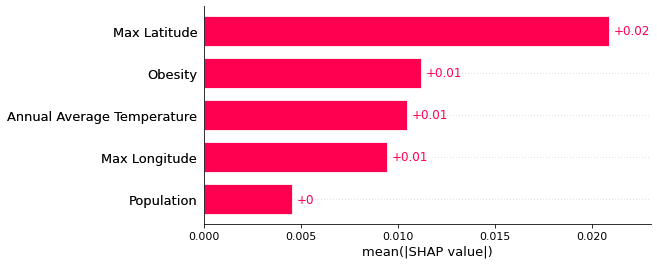

In [32]:
shap.plots.bar(shap_values)